## 1. Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib auto

Using matplotlib backend: module://matplotlib_inline.backend_inline


### 1.1. Read Data

In [2]:
df = pd.read_csv('laptop_data.csv')
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [3]:
df.columns

Index(['Unnamed: 0', 'Company', 'TypeName', 'Inches', 'ScreenResolution',
       'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price'],
      dtype='object')

In [4]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [5]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [6]:
df.isnull().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

In [7]:
df.duplicated().sum()

29

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 112.1+ KB


In [9]:
for column in df.columns:
    print(f"Column {column} after removing duplicate values: ", list(df[column].unique()))
    print("-"*30)

Column Company after removing duplicate values:  ['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI', 'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer', 'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG']
------------------------------
Column TypeName after removing duplicate values:  ['Ultrabook', 'Notebook', 'Netbook', 'Gaming', '2 in 1 Convertible', 'Workstation']
------------------------------
Column Inches after removing duplicate values:  [13.3, 15.6, 15.4, 14.0, 12.0, 11.6, 17.3, 10.1, 13.5, 12.5, 13.0, 18.4, 13.9, 12.3, 17.0, 15.0, 14.1, 11.3]
------------------------------
Column ScreenResolution after removing duplicate values:  ['IPS Panel Retina Display 2560x1600', '1440x900', 'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800', '1366x768', 'IPS Panel Full HD 1920x1080', 'IPS Panel Retina Display 2304x1440', 'IPS Panel Full HD / Touchscreen 1920x1080', 'Full HD / Touchscreen 1920x1080', 'Touchscreen / Quad HD+ 3200x1800', 'IPS Panel Touchscreen 19

In [10]:
df['Ram'].unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '6GB', '32GB', '24GB', '64GB'],
      dtype=object)

In [11]:
df['Ram'] = df['Weight'].str.replace('kg','').astype('float32')

In [12]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,1.37,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,1.34,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,1.86,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,1.83,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,1.37,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [13]:
df['Weight'].unique()

array(['1.37kg', '1.34kg', '1.86kg', '1.83kg', '2.1kg', '2.04kg', '1.3kg',
       '1.6kg', '2.2kg', '0.92kg', '1.22kg', '0.98kg', '2.5kg', '1.62kg',
       '1.91kg', '2.3kg', '1.35kg', '1.88kg', '1.89kg', '1.65kg',
       '2.71kg', '1.2kg', '1.44kg', '2.8kg', '2kg', '2.65kg', '2.77kg',
       '3.2kg', '0.69kg', '1.49kg', '2.4kg', '2.13kg', '2.43kg', '1.7kg',
       '1.4kg', '1.8kg', '1.9kg', '3kg', '1.252kg', '2.7kg', '2.02kg',
       '1.63kg', '1.96kg', '1.21kg', '2.45kg', '1.25kg', '1.5kg',
       '2.62kg', '1.38kg', '1.58kg', '1.85kg', '1.23kg', '1.26kg',
       '2.16kg', '2.36kg', '2.05kg', '1.32kg', '1.75kg', '0.97kg',
       '2.9kg', '2.56kg', '1.48kg', '1.74kg', '1.1kg', '1.56kg', '2.03kg',
       '1.05kg', '4.4kg', '1.90kg', '1.29kg', '2.0kg', '1.95kg', '2.06kg',
       '1.12kg', '1.42kg', '3.49kg', '3.35kg', '2.23kg', '4.42kg',
       '2.69kg', '2.37kg', '4.7kg', '3.6kg', '2.08kg', '4.3kg', '1.68kg',
       '1.41kg', '4.14kg', '2.18kg', '2.24kg', '2.67kg', '2.14kg',
       '1.

In [14]:
df['Ram'].unique()

array([1.37 , 1.34 , 1.86 , 1.83 , 2.1  , 2.04 , 1.3  , 1.6  , 2.2  ,
       0.92 , 1.22 , 0.98 , 2.5  , 1.62 , 1.91 , 2.3  , 1.35 , 1.88 ,
       1.89 , 1.65 , 2.71 , 1.2  , 1.44 , 2.8  , 2.   , 2.65 , 2.77 ,
       3.2  , 0.69 , 1.49 , 2.4  , 2.13 , 2.43 , 1.7  , 1.4  , 1.8  ,
       1.9  , 3.   , 1.252, 2.7  , 2.02 , 1.63 , 1.96 , 1.21 , 2.45 ,
       1.25 , 1.5  , 2.62 , 1.38 , 1.58 , 1.85 , 1.23 , 1.26 , 2.16 ,
       2.36 , 2.05 , 1.32 , 1.75 , 0.97 , 2.9  , 2.56 , 1.48 , 1.74 ,
       1.1  , 1.56 , 2.03 , 1.05 , 4.4  , 1.29 , 1.95 , 2.06 , 1.12 ,
       1.42 , 3.49 , 3.35 , 2.23 , 4.42 , 2.69 , 2.37 , 4.7  , 3.6  ,
       2.08 , 4.3  , 1.68 , 1.41 , 4.14 , 2.18 , 2.24 , 2.67 , 2.14 ,
       1.36 , 2.25 , 2.15 , 2.19 , 2.54 , 3.42 , 1.28 , 2.33 , 1.45 ,
       2.79 , 1.84 , 2.6  , 2.26 , 3.25 , 1.59 , 1.13 , 1.78 , 1.15 ,
       1.27 , 1.43 , 2.31 , 1.16 , 1.64 , 2.17 , 1.47 , 3.78 , 1.79 ,
       0.91 , 1.99 , 4.33 , 1.93 , 1.87 , 2.63 , 3.4  , 3.14 , 1.94 ,
       1.24 , 4.6  ,

In [15]:
df['Ram'] = df['Ram'].replace('GB','').astype('int32')

In [16]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,1,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,1,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [17]:
df['Weight'].unique()

array(['1.37kg', '1.34kg', '1.86kg', '1.83kg', '2.1kg', '2.04kg', '1.3kg',
       '1.6kg', '2.2kg', '0.92kg', '1.22kg', '0.98kg', '2.5kg', '1.62kg',
       '1.91kg', '2.3kg', '1.35kg', '1.88kg', '1.89kg', '1.65kg',
       '2.71kg', '1.2kg', '1.44kg', '2.8kg', '2kg', '2.65kg', '2.77kg',
       '3.2kg', '0.69kg', '1.49kg', '2.4kg', '2.13kg', '2.43kg', '1.7kg',
       '1.4kg', '1.8kg', '1.9kg', '3kg', '1.252kg', '2.7kg', '2.02kg',
       '1.63kg', '1.96kg', '1.21kg', '2.45kg', '1.25kg', '1.5kg',
       '2.62kg', '1.38kg', '1.58kg', '1.85kg', '1.23kg', '1.26kg',
       '2.16kg', '2.36kg', '2.05kg', '1.32kg', '1.75kg', '0.97kg',
       '2.9kg', '2.56kg', '1.48kg', '1.74kg', '1.1kg', '1.56kg', '2.03kg',
       '1.05kg', '4.4kg', '1.90kg', '1.29kg', '2.0kg', '1.95kg', '2.06kg',
       '1.12kg', '1.42kg', '3.49kg', '3.35kg', '2.23kg', '4.42kg',
       '2.69kg', '2.37kg', '4.7kg', '3.6kg', '2.08kg', '4.3kg', '1.68kg',
       '1.41kg', '4.14kg', '2.18kg', '2.24kg', '2.67kg', '2.14kg',
       '1.

In [18]:
df['Weight'] = df['Weight'].str.replace('kg','').astype('float32')

In [19]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,1,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,1,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080


In [20]:
catvars = df.select_dtypes(include=['object']).columns
numvars = df.select_dtypes(include=['int32','int64','float32','float64']).columns

catvars, numvars

(Index(['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu',
        'OpSys'],
       dtype='object'),
 Index(['Inches', 'Ram', 'Weight', 'Price'], dtype='object'))

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   int32  
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   float32
 10  Price             1303 non-null   float64
dtypes: float32(1), float64(2), int32(1), object(7)
memory usage: 101.9+ KB


## 2. Exploratory Data Analysis

### 2.1. Price Prediction

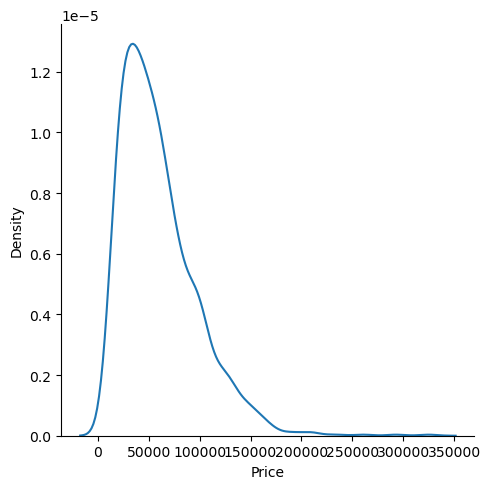

In [22]:
sns.displot(df['Price'], kind="kde")
plt.show()

### 2.2. Distribution of number of laptops in different companies

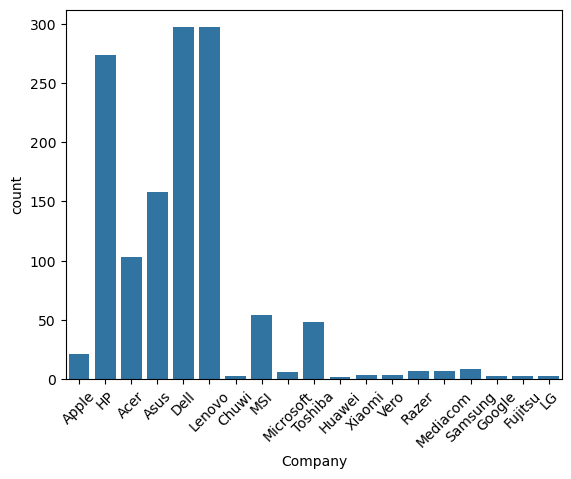

In [23]:
sns.countplot(data=df,x="Company")
plt.xticks(rotation=45)
plt.show()

In [24]:
df["Company"].value_counts()

Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: count, dtype: int64

### 2.3. Distribution of number of laptops for different types

In [25]:
df["TypeName"].value_counts()

TypeName
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: count, dtype: int64

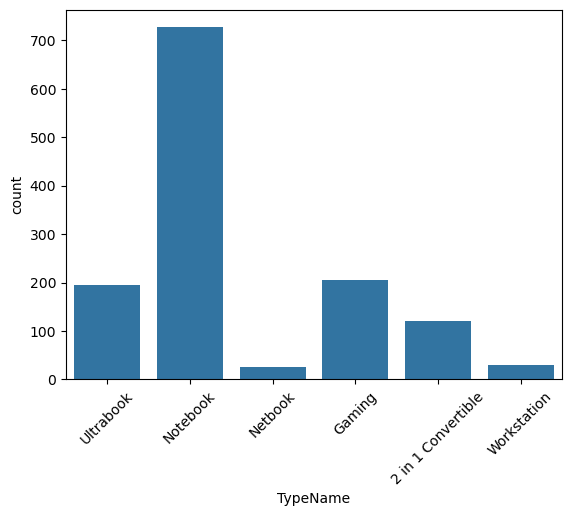

In [26]:
sns.countplot(data=df, x="TypeName")
plt.xticks(rotation=45)
plt.show()

### 2.4. Distribution of number of laptops for different operating systems 

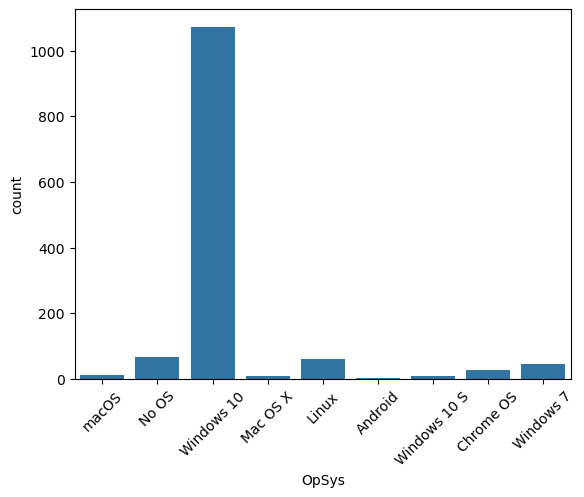

In [27]:
sns.countplot(data=df, x="OpSys")
plt.xticks(rotation=45)
plt.show()

In [28]:
df.head(3)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000


### 2.5. Company vs. Price

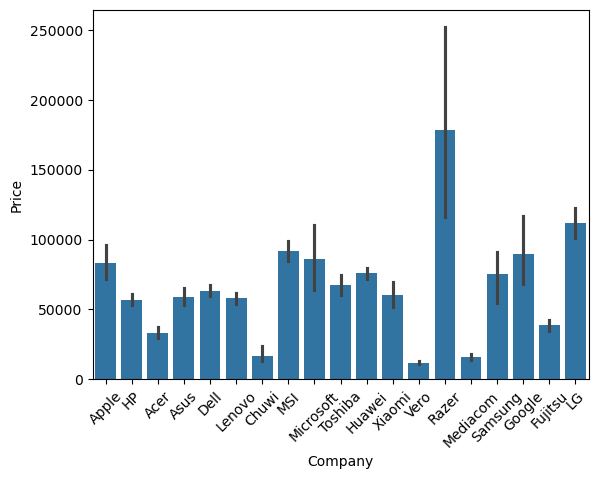

In [29]:
sns.barplot(df,x="Company",y="Price")
plt.xticks(rotation=45)
plt.show()

### 2.6. Laptop Types vs. Price

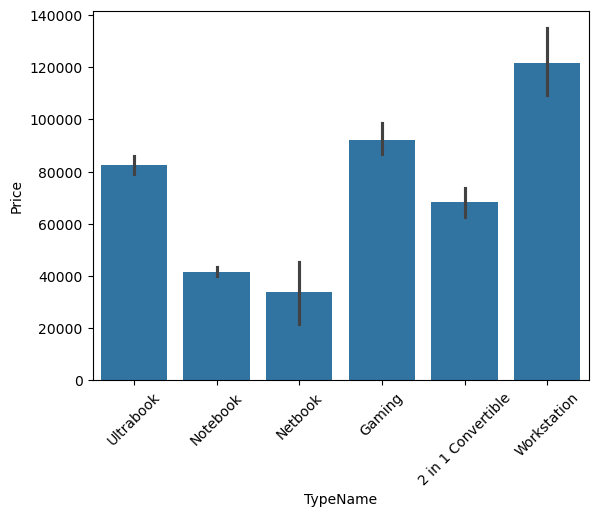

In [30]:
sns.barplot(df,x="TypeName",y="Price")
plt.xticks(rotation=45)
plt.show()

### 2.7. Laptop size vs. Price

<Axes: xlabel='Inches', ylabel='Price'>

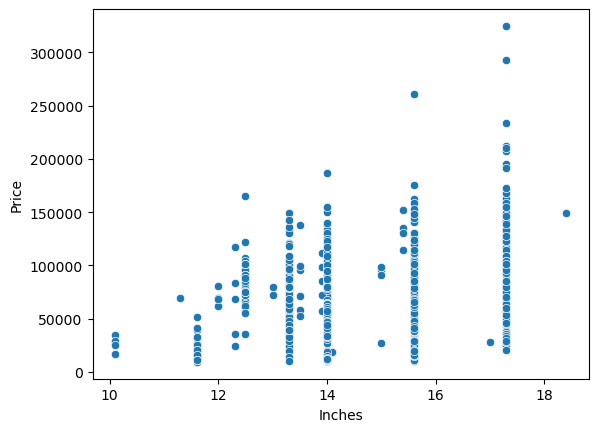

In [31]:
sns.scatterplot(df,x='Inches',y='Price')

### 2.8. Screen resolution traits extraction

#### 2.8.1 TouchScreen

In [32]:
df['TouchScreen'] = df['ScreenResolution'].map(lambda x:1 if 'Touchscreen' in x else 0)
df.sample(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen
893,Lenovo,Ultrabook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,Windows 10,1.32,95850.72,0
456,Dell,Notebook,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.7GHz,4,1TB HDD,Nvidia GeForce GTX 1060,Windows 10,4.42,109010.88,0
517,Asus,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,2,512GB SSD,Nvidia GeForce GTX1080,Windows 10,2.24,158135.04,0
49,Asus,Notebook,17.3,1366x768,Intel Pentium Quad Core N4200 1.1GHz,2,1TB HDD,Nvidia GeForce 920MX,Windows 10,2.80,24828.48,0
870,Lenovo,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,2,500GB HDD,Intel HD Graphics 620,Windows 10,2.38,56210.40,0


<Axes: xlabel='TouchScreen', ylabel='count'>

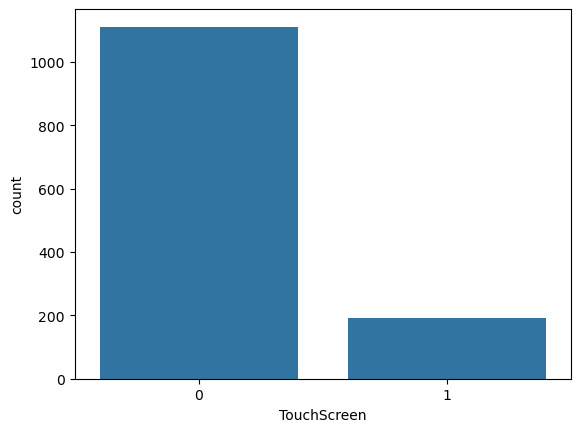

In [33]:
sns.countplot(df, x='TouchScreen')

<Axes: xlabel='TouchScreen', ylabel='Price'>

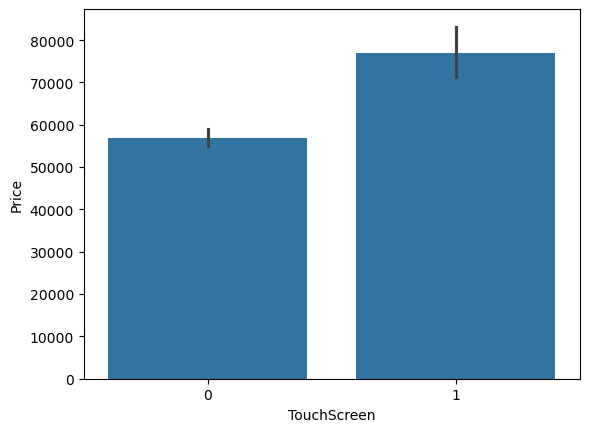

In [34]:
sns.barplot(df, x='TouchScreen', y = 'Price')

#### 2.8.2 IPS

In [35]:
df['IPS'] = df['ScreenResolution'].map(lambda x:1 if 'IPS' in x else 0)
df.sample(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,IPS
1200,Dell,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,2,128GB SSD,AMD Radeon R7 M440,Windows 10,2.30,26586.72,0,0
159,Toshiba,Notebook,15.6,1366x768,Intel Core i3 6006U 2.2GHz,2,500GB HDD,Intel HD Graphics 520,Windows 10,2.10,23816.16,0,0
1126,Lenovo,2 in 1 Convertible,10.1,IPS Panel Touchscreen 1920x1200,Intel Atom x5-Z8550 1.44GHz,0,64GB Flash Storage,Intel HD Graphics 400,Windows 10,0.69,25521.12,1,1
797,Dell,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,1,128GB SSD,Intel HD Graphics 620,Windows 10,1.95,43156.80,0,0
478,Dell,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,2,1TB HDD,AMD Radeon 520,Windows 10,2.20,35964.00,0,0


<Axes: xlabel='IPS', ylabel='count'>

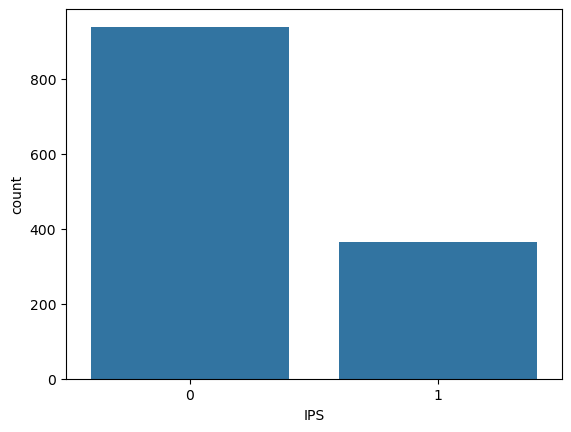

In [36]:
sns.countplot(df, x='IPS')

<Axes: xlabel='IPS', ylabel='Price'>

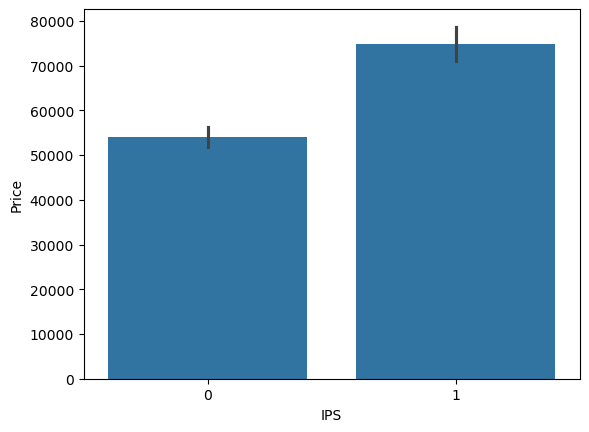

In [37]:
sns.barplot(df, x='IPS', y='Price')

#### 2.8.3 Extract X and Y resolution

In [38]:
df['ScreenResolution'].unique()

array(['IPS Panel Retina Display 2560x1600', '1440x900',
       'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800',
       '1366x768', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'Full HD / Touchscreen 1920x1080',
       'Touchscreen / Quad HD+ 3200x1800',
       'IPS Panel Touchscreen 1920x1200', 'Touchscreen 2256x1504',
       'Quad HD+ / Touchscreen 3200x1800', 'IPS Panel 1366x768',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2160x1440',
       '4K Ultra HD / Touchscreen 3840x2160', 'Touchscreen 2560x1440',
       '1600x900', 'IPS Panel 4K Ultra HD 3840x2160',
       '4K Ultra HD 3840x2160', 'Touchscreen 1366x768',
       'IPS Panel Full HD 1366x768', 'IPS Panel 2560x1440',
       'IPS Panel Full HD 2560x1440',
       'IPS Panel Retina Display 2736x1824', 'Touchscreen 2400x1600',
       '2560x1440', 'IPS Panel Quad HD+ 2560x1440',
       'IPS Panel 

In [39]:
import re

In [40]:
pattern = r"(\d+)x(\d+)"

In [41]:
def get_xy_res(row):
    matches = re.search(pattern, row["ScreenResolution"]).groups(0)
    return int(matches[0]), int(matches[1])

In [42]:
df[["X_res","Y_res"]] = df.apply(get_xy_res, axis=1, result_type="expand")

In [43]:
df.head(3)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,IPS,X_res,Y_res
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,2560,1600
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,1440,900
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,1920,1080


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   int32  
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   float32
 10  Price             1303 non-null   float64
 11  TouchScreen       1303 non-null   int64  
 12  IPS               1303 non-null   int64  
 13  X_res             1303 non-null   int64  
 14  Y_res             1303 non-null   int64  
dtypes: float32(1), float64(2), int32(1), int64(4), object(7)
memory usage: 142.6+ KB


<Axes: >

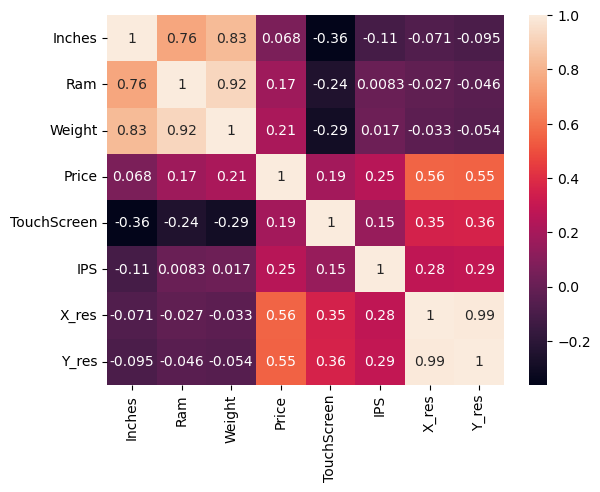

In [45]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

In [46]:
df.corr(numeric_only=True)['Price'].sort_values()

Inches         0.068197
Ram            0.173722
TouchScreen    0.191226
Weight         0.210370
IPS            0.252208
Y_res          0.552809
X_res          0.556529
Price          1.000000
Name: Price, dtype: float64

#### 2.8.4 Construct PPI

As we can see from the above heatmap, there is a very high correlation between X_res and Y_res. I will construct a new variable called PPI, given X_res, Y_res, and Inches. After that, I will delete X_res, Y_res, and Inches for the sake of retaining model training accruacy later on.

The formula to calculate PPI is below:

## $PPI = \frac{\sqrt{X^2+Y^2}}{Screen Resolution}$

In [47]:
df['PPI']=(((df['X_res']**2+df['Y_res']**2))**0.5/df['Inches']).astype(float)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,IPS,X_res,Y_res,PPI
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,2560,1600,226.983005
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,1440,900,127.677940
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,1920,1080,141.211998
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,1,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,2880,1800,220.534624
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,1,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,2560,1600,226.983005


In [48]:
df.corr(numeric_only=True)

,Inches,Ram,Weight,Price,TouchScreen,IPS,X_res,Y_res,PPI
Inches,1.000000,0.755337,0.827631,0.068197,-0.361735,-0.114804,-0.071245,-0.095404,-0.414804
Ram,0.755337,1.000000,0.921411,0.173722,-0.244727,0.008324,-0.026558,-0.046330,-0.292408
Weight,0.827631,0.921411,1.000000,0.210370,-0.294620,0.016967,-0.032880,-0.053846,-0.323240
Price,0.068197,0.173722,0.210370,1.000000,0.191226,0.252208,0.556529,0.552809,0.473487
TouchScreen,-0.361735,-0.244727,-0.294620,0.191226,1.000000,0.150512,0.351066,0.357930,0.460587
IPS,-0.114804,0.008324,0.016967,0.252208,0.150512,1.000000,0.281457,0.289030,0.300879
X_res,-0.071245,-0.026558,-0.032880,0.556529,0.351066,0.281457,1.000000,0.994219,0.931217
Y_res,-0.095404,-0.046330,-0.053846,0.552809,0.357930,0.289030,0.994219,1.000000,0.939363
PPI,-0.414804,-0.292408,-0.323240,0.473487,0.460587,0.300879,0.931217,0.939363,1.000000


In [49]:
df.corr(numeric_only=True)['Price'].sort_values()

Inches         0.068197
Ram            0.173722
TouchScreen    0.191226
Weight         0.210370
IPS            0.252208
PPI            0.473487
Y_res          0.552809
X_res          0.556529
Price          1.000000
Name: Price, dtype: float64

In [50]:
data_enums = {}
data_enums["ScreenResolution"] = list(df.apply(lambda x : "%dX%d" %(x["X_res"],x["Y_res"]),axis=1).unique())

In [51]:
data_enums["Inches"]=round(float(df["Inches"].mean()),2)

In [52]:
df.drop(columns=['ScreenResolution','Inches','X_res','Y_res'],inplace=True)
df.head()

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,IPS,PPI
0,Apple,Ultrabook,Intel Core i5 2.3GHz,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,226.983005
1,Apple,Ultrabook,Intel Core i5 1.8GHz,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,127.677940
2,HP,Notebook,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,141.211998
3,Apple,Ultrabook,Intel Core i7 2.7GHz,1,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,220.534624
4,Apple,Ultrabook,Intel Core i5 3.1GHz,1,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,226.983005


### 2.9 CPU Management

In [53]:
df['Cpu'].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz       190
Intel Core i7 7700HQ 2.8GHz      146
Intel Core i7 7500U 2.7GHz       134
Intel Core i7 8550U 1.8GHz        73
Intel Core i5 8250U 1.6GHz        72
                                ... 
Intel Core M M3-6Y30 0.9GHz        1
AMD A9-Series 9420 2.9GHz          1
Intel Core i3 6006U 2.2GHz         1
AMD A6-Series 7310 2GHz            1
Intel Xeon E3-1535M v6 3.1GHz      1
Name: count, Length: 118, dtype: int64

In [54]:
def get_cpu_name(cpu_text):
    if "Intel Core i7" in cpu_text:
        return "Intel Core i7"
    elif "Intel Core i5" in cpu_text:
        return "Intel Core i5"
    elif "Intel Core i3" in cpu_text:
        return "Intel Core i3"
    elif "Intel" in cpu_text:
        return "Intel Other"
    elif "AMD" in cpu_text:
        return "AMD"
    else:
        return "Other"

In [55]:
df['CPU_name']=df['Cpu'].map(get_cpu_name)
df.head()

,Company,TypeName,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name
0,Apple,Ultrabook,Intel Core i5 2.3GHz,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,226.983005,Intel Core i5
1,Apple,Ultrabook,Intel Core i5 1.8GHz,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,127.677940,Intel Core i5
2,HP,Notebook,Intel Core i5 7200U 2.5GHz,1,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,141.211998,Intel Core i5
3,Apple,Ultrabook,Intel Core i7 2.7GHz,1,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,220.534624,Intel Core i7
4,Apple,Ultrabook,Intel Core i5 3.1GHz,1,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,226.983005,Intel Core i5


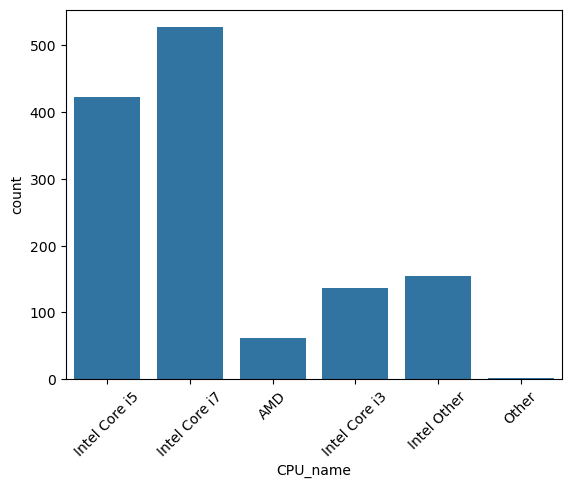

In [56]:
sns.countplot(df, x='CPU_name')
plt.xticks(rotation=45)
plt.show()

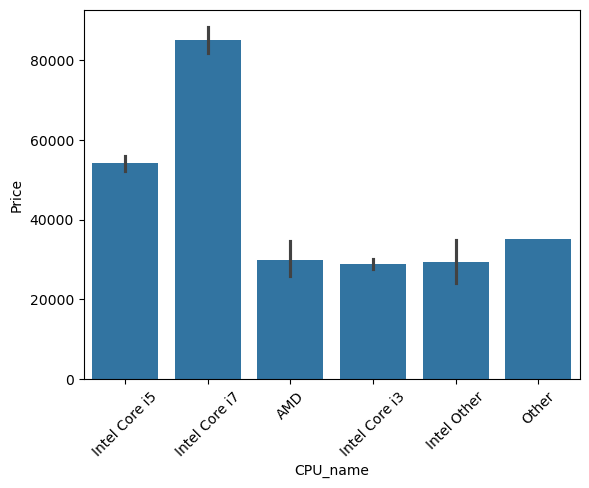

In [57]:
sns.barplot(df, x='CPU_name', y='Price')
plt.xticks(rotation=45)
plt.show()

In [58]:
df.drop(columns=['Cpu'], inplace=True)
df.head()

,Company,TypeName,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name
0,Apple,Ultrabook,1,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,226.983005,Intel Core i5
1,Apple,Ultrabook,1,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,127.677940,Intel Core i5
2,HP,Notebook,1,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,141.211998,Intel Core i5
3,Apple,Ultrabook,1,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,220.534624,Intel Core i7
4,Apple,Ultrabook,1,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,226.983005,Intel Core i5


### 2.10 RAM Management

In [59]:
df["Ram"].value_counts()

Ram
2    628
1    568
3     54
4     35
0     18
Name: count, dtype: int64

<Axes: xlabel='Ram', ylabel='count'>

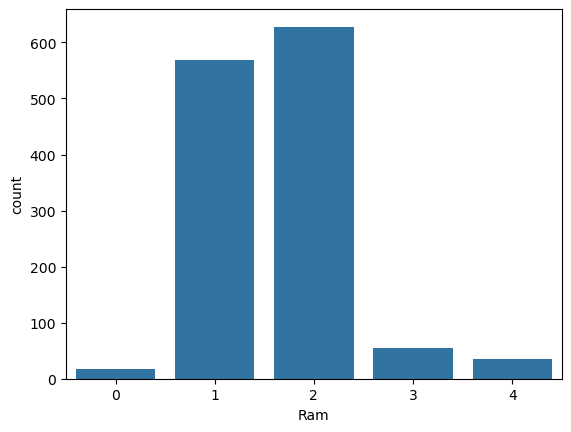

In [60]:
sns.countplot(df, x='Ram')

<Axes: xlabel='Ram', ylabel='Price'>

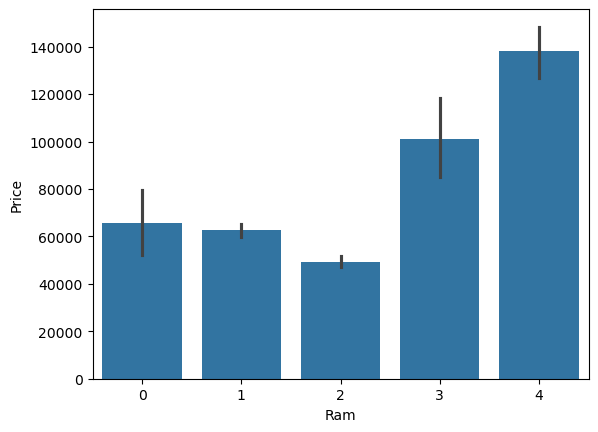

In [61]:
sns.barplot(df, x='Ram',y='Price')

### 2.11 Memory

In [62]:
df['Memory'].value_counts()

Memory
256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD         

Based on the observations, disk drive has four major types: SSD, HDD, Hybrid, and Storage. We can split them into four columns

In [63]:
def get_clean_number(value):
    pattern = "\d+"
    result = re.findall(pattern, value)
    return int(result[0])

get_clean_number("512GB SSD ")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/dw/m8pw4cwn0477kw5tlf3t4jb80000gn/T/ipykernel_56475/1498837209.py:2: SyntaxWarning: invalid escape sequence '\d'
  pattern = "\d+"


512

In [64]:
def get_memory_types(row):
    memory = row["Memory"]
    memory = memory.replace(".0", "")
    memory = memory.replace("TB", "000")
    SSD, HDD, Hybrid, Flash = [],[],[],[]
    splits = memory.split("+")
    for split in splits:
        if "SSD" in split:
            SSD.append(get_clean_number(split))
        if "HDD" in split:
            HDD.append(get_clean_number(split))     
        if "Hybrid" in split:
            Hybrid.append(get_clean_number(split))
        if "Flash" in split:
            Flash.append(get_clean_number(split))
    SSD = sum(SSD) if len(SSD)>0 else 0
    HDD = sum(HDD) if len(HDD)>0 else 0
    Hybrid = sum(Hybrid) if len(Hybrid)>0 else 0
    Flash = sum(Flash) if len(Flash)>0 else 0
    return SSD, HDD, Hybrid, Flash

get_memory_types({"Memory": "512GB SSD +  1.0TB Hybrid"})

(512, 0, 1000, 0)

In [65]:
df[["SSD","HDD","Hybrid","Flash"]] = df.apply(get_memory_types, axis=1, result_type="expand")

In [66]:
df.sample(5)

,Company,TypeName,Ram,Memory,Gpu,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name,SSD,HDD,Hybrid,Flash
876,Asus,Notebook,2,1TB HDD,Intel HD Graphics 505,Linux,2.00,21258.1872,0,0,100.454670,Intel Other,0,1000,0,0
1186,Dell,2 in 1 Convertible,2,512GB SSD,Intel HD Graphics 620,Windows 10,2.09,62817.1200,1,0,141.211998,Intel Core i7,512,0,0,0
1143,HP,Workstation,2,256GB SSD,Nvidia Quadro M1000M,Windows 7,2.59,118761.1200,0,1,141.211998,Intel Core i7,256,0,0,0
391,Asus,Gaming,3,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows 10,3.00,84768.4800,0,0,127.335675,Intel Core i7,256,1000,0,0
734,Lenovo,Notebook,1,256GB SSD,Intel HD Graphics 620,Windows 10,1.44,51148.8000,0,1,165.632118,Intel Core i5,256,0,0,0


In [67]:
df.drop(columns=['Memory'],inplace=True)
df.sample(5)

,Company,TypeName,Ram,Gpu,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name,SSD,HDD,Hybrid,Flash
453,Lenovo,Notebook,1,Intel HD Graphics 620,Windows 10,1.65,71661.6000,0,0,157.350512,Intel Core i5,256,0,0,0
157,Asus,2 in 1 Convertible,1,Intel HD Graphics 620,Windows 10,1.10,70063.2000,1,0,165.632118,Intel Core i5,256,0,0,0
830,Razer,Gaming,3,Nvidia GeForce GTX 1080,Windows 10,3.49,292986.7200,1,0,254.671349,Intel Core i7,512,0,0,0
13,Dell,Notebook,2,AMD Radeon R5 M430,Windows 10,2.20,26581.3920,0,0,141.211998,Intel Core i3,256,0,0,0
215,Dell,Ultrabook,1,AMD Radeon 530,Windows 10,1.40,49650.5664,0,1,165.632118,Intel Core i7,256,0,0,0


In [68]:
df.corr(numeric_only=True)['Price'].sort_values()

HDD           -0.096441
Flash         -0.040511
Hybrid         0.007989
Ram            0.173722
TouchScreen    0.191226
Weight         0.210370
IPS            0.252208
PPI            0.473487
SSD            0.670799
Price          1.000000
Name: Price, dtype: float64

From the correlation matrix above, we can tell that Hybrid and Flash both have extremely low correlation with Price, so we can remove them later. Meanwhile, Although HDD has low correlation as well, its absolute value is higher than both Hybrid and Flash and we can infer that if we were to include HDD as part of our price prediction, it would result in a lower price, in contrast to SSD. Therefore, we keep HDD as part of our data analysis.

In [69]:
df.columns

Index(['Company', 'TypeName', 'Ram', 'Gpu', 'OpSys', 'Weight', 'Price',
       'TouchScreen', 'IPS', 'PPI', 'CPU_name', 'SSD', 'HDD', 'Hybrid',
       'Flash'],
      dtype='object')

In [70]:
df.drop(columns=['Hybrid','Flash'], inplace=True)
df.head()

,Company,TypeName,Ram,Gpu,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name,SSD,HDD
0,Apple,Ultrabook,1,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,0,1,226.983005,Intel Core i5,128,0
1,Apple,Ultrabook,1,Intel HD Graphics 6000,macOS,1.34,47895.5232,0,0,127.677940,Intel Core i5,0,0
2,HP,Notebook,1,Intel HD Graphics 620,No OS,1.86,30636.0000,0,0,141.211998,Intel Core i5,256,0
3,Apple,Ultrabook,1,AMD Radeon Pro 455,macOS,1.83,135195.3360,0,1,220.534624,Intel Core i7,512,0
4,Apple,Ultrabook,1,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,0,1,226.983005,Intel Core i5,256,0


### 2.12. GPU Management

In [71]:
df['Gpu'].value_counts()

Gpu
Intel HD Graphics 620      281
Intel HD Graphics 520      185
Intel UHD Graphics 620      68
Nvidia GeForce GTX 1050     66
Nvidia GeForce GTX 1060     48
                          ... 
AMD Radeon R5 520            1
AMD Radeon R7                1
Intel HD Graphics 540        1
AMD Radeon 540               1
ARM Mali T860 MP4            1
Name: count, Length: 110, dtype: int64

GPU has many brands, and we only want to focus on brands like Intel or AMD

In [72]:
df['Gpu brand']=df['Gpu'].apply(lambda x:x.split()[0])

<Axes: xlabel='Gpu brand', ylabel='count'>

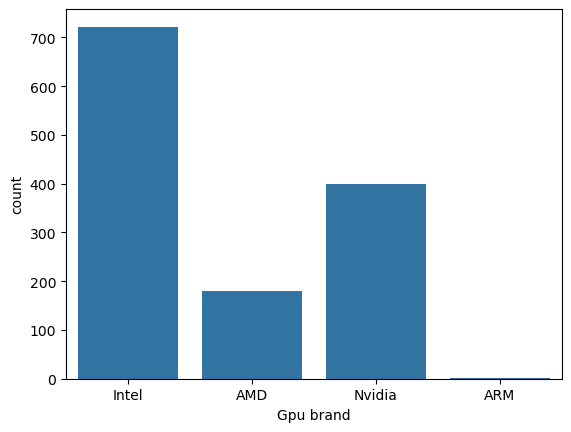

In [73]:
sns.countplot(df,x='Gpu brand')

<Axes: xlabel='Gpu brand', ylabel='Price'>

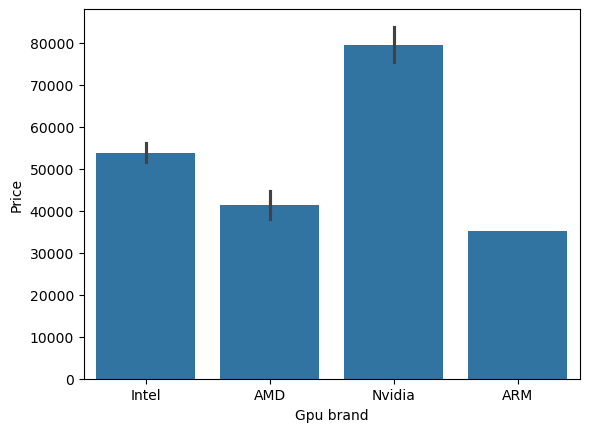

In [74]:
sns.barplot(df,x='Gpu brand',y='Price')

In [75]:
df=df.drop(columns=['Gpu'])
df.head()

,Company,TypeName,Ram,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name,SSD,HDD,Gpu brand
0,Apple,Ultrabook,1,macOS,1.37,71378.6832,0,1,226.983005,Intel Core i5,128,0,Intel
1,Apple,Ultrabook,1,macOS,1.34,47895.5232,0,0,127.677940,Intel Core i5,0,0,Intel
2,HP,Notebook,1,No OS,1.86,30636.0000,0,0,141.211998,Intel Core i5,256,0,Intel
3,Apple,Ultrabook,1,macOS,1.83,135195.3360,0,1,220.534624,Intel Core i7,512,0,AMD
4,Apple,Ultrabook,1,macOS,1.37,96095.8080,0,1,226.983005,Intel Core i5,256,0,Intel


### 2.13 Operating System Management

In [76]:
df['OpSys'].value_counts()

OpSys
Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: count, dtype: int64

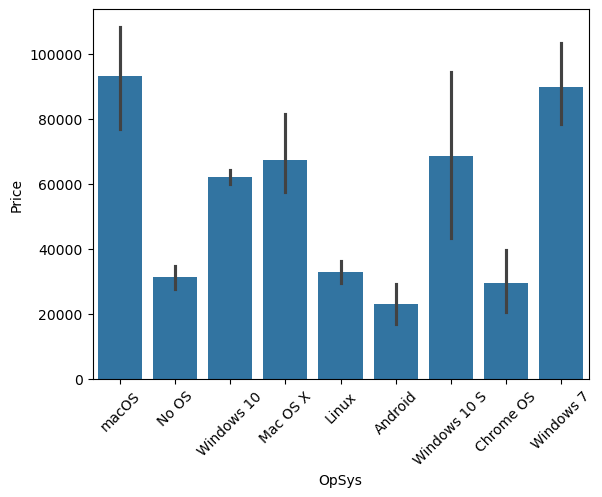

In [77]:
sns.barplot(df, x='OpSys', y='Price')
plt.xticks(rotation=45)
plt.show()

In [78]:
df['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

In [79]:
def setcategory(op_sys):
    if op_sys in ['Windows 10', 'Windows 10 S', 'Windows 7']:
        return 'Windows'
    elif op_sys in ['Mac OS X','macOS']:
        return 'Mac'
    else:
        return 'Other'

df['OpSys'] = df['OpSys'].map(setcategory)
df.head()

,Company,TypeName,Ram,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name,SSD,HDD,Gpu brand
0,Apple,Ultrabook,1,Mac,1.37,71378.6832,0,1,226.983005,Intel Core i5,128,0,Intel
1,Apple,Ultrabook,1,Mac,1.34,47895.5232,0,0,127.677940,Intel Core i5,0,0,Intel
2,HP,Notebook,1,Other,1.86,30636.0000,0,0,141.211998,Intel Core i5,256,0,Intel
3,Apple,Ultrabook,1,Mac,1.83,135195.3360,0,1,220.534624,Intel Core i7,512,0,AMD
4,Apple,Ultrabook,1,Mac,1.37,96095.8080,0,1,226.983005,Intel Core i5,256,0,Intel


<Axes: xlabel='OpSys', ylabel='count'>

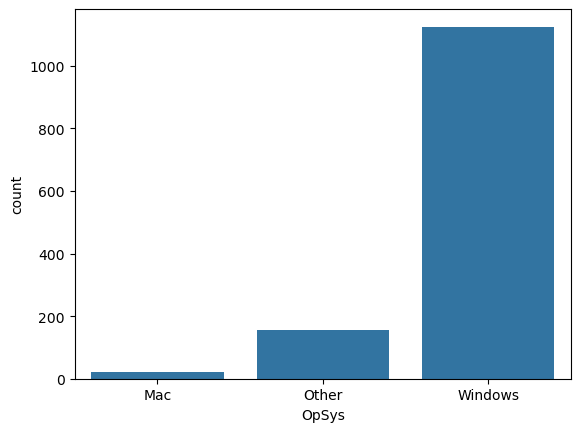

In [80]:
sns.countplot(df,x='OpSys')

<Axes: xlabel='OpSys', ylabel='Price'>

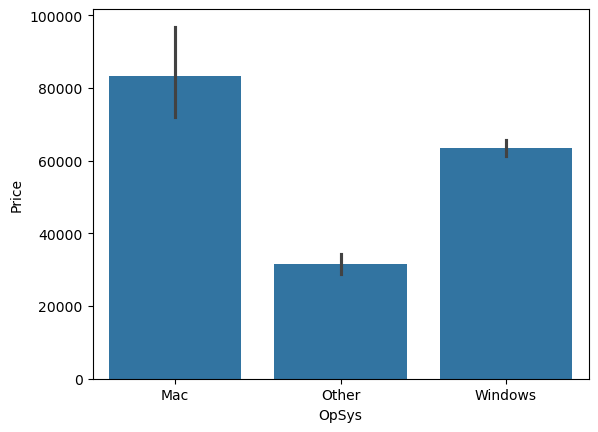

In [81]:
sns.barplot(df,x='OpSys',y='Price')

### 2.14 Weight Management

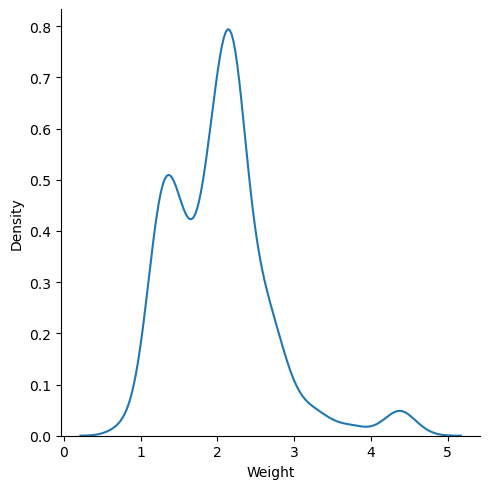

In [82]:
sns.displot(df['Weight'],kind='kde')

<Axes: xlabel='Weight', ylabel='Price'>

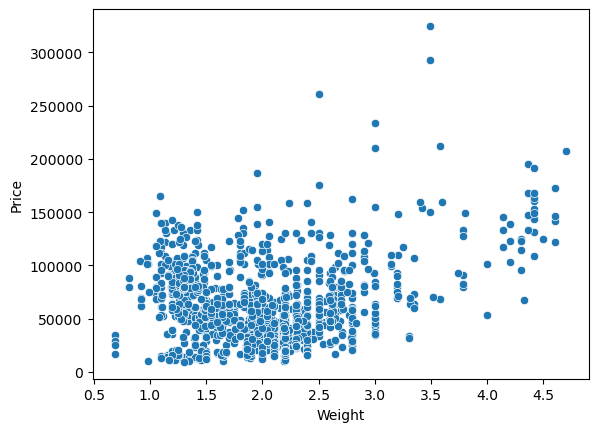

In [83]:
sns.scatterplot(df, x='Weight',y='Price')

### 2.15 Price Analysis

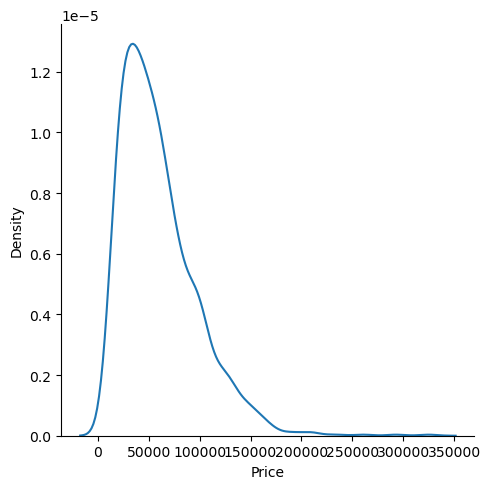

In [84]:
sns.displot(df['Price'], kind='kde')

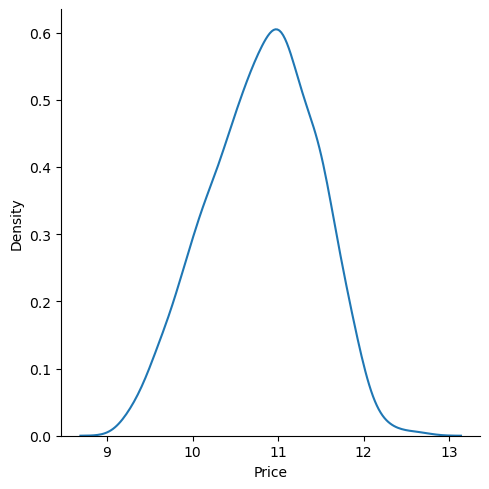

In [85]:
sns.displot(np.log(df['Price']),kind='kde')

In [86]:
df.corr(numeric_only=True)['Price'].sort_values()

HDD           -0.096441
Ram            0.173722
TouchScreen    0.191226
Weight         0.210370
IPS            0.252208
PPI            0.473487
SSD            0.670799
Price          1.000000
Name: Price, dtype: float64

<Axes: >

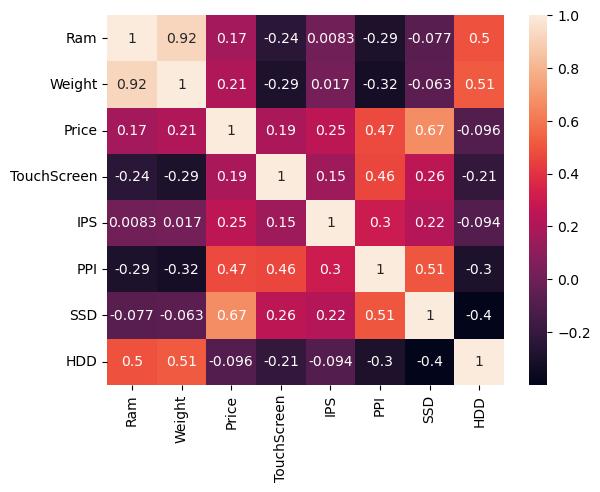

In [87]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [88]:
df.head()

,Company,TypeName,Ram,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name,SSD,HDD,Gpu brand
0,Apple,Ultrabook,1,Mac,1.37,71378.6832,0,1,226.983005,Intel Core i5,128,0,Intel
1,Apple,Ultrabook,1,Mac,1.34,47895.5232,0,0,127.677940,Intel Core i5,0,0,Intel
2,HP,Notebook,1,Other,1.86,30636.0000,0,0,141.211998,Intel Core i5,256,0,Intel
3,Apple,Ultrabook,1,Mac,1.83,135195.3360,0,1,220.534624,Intel Core i7,512,0,AMD
4,Apple,Ultrabook,1,Mac,1.37,96095.8080,0,1,226.983005,Intel Core i5,256,0,Intel


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1303 non-null   object 
 1   TypeName     1303 non-null   object 
 2   Ram          1303 non-null   int32  
 3   OpSys        1303 non-null   object 
 4   Weight       1303 non-null   float32
 5   Price        1303 non-null   float64
 6   TouchScreen  1303 non-null   int64  
 7   IPS          1303 non-null   int64  
 8   PPI          1303 non-null   float64
 9   CPU_name     1303 non-null   object 
 10  SSD          1303 non-null   int64  
 11  HDD          1303 non-null   int64  
 12  Gpu brand    1303 non-null   object 
dtypes: float32(1), float64(2), int32(1), int64(4), object(5)
memory usage: 122.3+ KB


### 2.16 Save data for UI development

In [90]:
df.head()

,Company,TypeName,Ram,OpSys,Weight,Price,TouchScreen,IPS,PPI,CPU_name,SSD,HDD,Gpu brand
0,Apple,Ultrabook,1,Mac,1.37,71378.6832,0,1,226.983005,Intel Core i5,128,0,Intel
1,Apple,Ultrabook,1,Mac,1.34,47895.5232,0,0,127.677940,Intel Core i5,0,0,Intel
2,HP,Notebook,1,Other,1.86,30636.0000,0,0,141.211998,Intel Core i5,256,0,Intel
3,Apple,Ultrabook,1,Mac,1.83,135195.3360,0,1,220.534624,Intel Core i7,512,0,AMD
4,Apple,Ultrabook,1,Mac,1.37,96095.8080,0,1,226.983005,Intel Core i5,256,0,Intel


In [91]:
for column in ["Company", "TypeName", "Ram", "OpSys", "CPU_name", "SSD", "HDD", "Gpu brand"]:
    data_enums[column] = [str(x) for x in df[column].unique()]

In [92]:
data_enums["Weight"]=round(float(df["Weight"].mean()),2)

In [93]:
data_enums

{'ScreenResolution': ['2560X1600',
  '1440X900',
  '1920X1080',
  '2880X1800',
  '1366X768',
  '2304X1440',
  '3200X1800',
  '1920X1200',
  '2256X1504',
  '3840X2160',
  '2160X1440',
  '2560X1440',
  '1600X900',
  '2736X1824',
  '2400X1600'],
 'Inches': 15.02,
 'Company': ['Apple',
  'HP',
  'Acer',
  'Asus',
  'Dell',
  'Lenovo',
  'Chuwi',
  'MSI',
  'Microsoft',
  'Toshiba',
  'Huawei',
  'Xiaomi',
  'Vero',
  'Razer',
  'Mediacom',
  'Samsung',
  'Google',
  'Fujitsu',
  'LG'],
 'TypeName': ['Ultrabook',
  'Notebook',
  'Netbook',
  'Gaming',
  '2 in 1 Convertible',
  'Workstation'],
 'Ram': ['1', '2', '0', '3', '4'],
 'OpSys': ['Mac', 'Other', 'Windows'],
 'CPU_name': ['Intel Core i5',
  'Intel Core i7',
  'AMD',
  'Intel Core i3',
  'Intel Other',
  'Other'],
 'SSD': ['128',
  '0',
  '256',
  '512',
  '32',
  '64',
  '1000',
  '1024',
  '16',
  '768',
  '180',
  '240',
  '8'],
 'HDD': ['0', '500', '1000', '2000', '32', '128'],
 'Gpu brand': ['Intel', 'AMD', 'Nvidia', 'ARM'],
 'We

In [94]:
import json
with open("data_enums.json","w",encoding="utf8") as f:
    f.write(json.dumps(data_enums, indent=4))

## 3. Model Training

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### 3.1 Split data into training and testing set

In [96]:
y = np.log(df['Price'])
X = df.drop(columns=['Price'], axis = 1)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=2)

X_train.shape, X_test.shape

((1107, 12), (196, 12))

In [98]:
mapper = {index:value for index,value in enumerate(X_train.columns)}
mapper

{0: 'Company',
 1: 'TypeName',
 2: 'Ram',
 3: 'OpSys',
 4: 'Weight',
 5: 'TouchScreen',
 6: 'IPS',
 7: 'PPI',
 8: 'CPU_name',
 9: 'SSD',
 10: 'HDD',
 11: 'Gpu brand'}

### 3.2 Linear Regression

In [99]:
step1 = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(drop='first'),[0,1,3,8,11])
], remainder='passthrough')

In [100]:
step2 = LinearRegression()

In [101]:
pipe = Pipeline([
    ('step1', step1),
    ('step2', step2)
])

In [102]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  [0, 1, 3, 8, 11])])),
                ('step2', LinearRegression())])

In [103]:
y_pred = pipe.predict(X_test)

In [104]:
print('R2 score', metrics.r2_score(y_test,y_pred))

R2 score 0.8142965019204381


In [105]:
print('MAE', metrics.mean_absolute_error(y_test, y_pred))

MAE 0.21883706701336403


In [106]:
np.exp(0.21)

1.2336780599567432